<a href="https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step4_train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepPoseKit Step 4 - Train a model

This is step 4 of the example notebooks for using DeepPoseKit. This notebook shows you how to use your annotated data to train a deep learning model using data augmentation and callbacks for logging the training process and saving the best model during training.

If you haven't already installed DeepPoseKit and downloaded the example datasets you can run the next cell

In [ ]:
!git clone https://github.com/jgraving/deepposekit-data ~/

import sys
!{sys.executable} -m pip install \
git+https://github.com/jgraving/deepposekit \
git+https://github.com/jgraving/deepposekit-annotator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob

from deepposekit import TrainingGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia

from deepposekit.models import (StackedDenseNet,
                                DeepLabCut,
                                StackedHourglass,
                                LEAP)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from deepposekit.callbacks import Logger, ModelCheckpoint

import time
from os.path import expanduser

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

HOME = expanduser("~") if not IN_COLAB else '.'

/Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/

In [2]:
annotations = sorted(glob.glob(HOME + '/deepposekit-data/datasets/fly/*.h5'))
annotations

['/Users/jake/deepposekit-data/datasets/fly/annotation_data_release.h5',
 '/Users/jake/deepposekit-data/datasets/fly/best_model_densenet.h5',
 '/Users/jake/deepposekit-data/datasets/fly/example_annotation_set.h5',
 '/Users/jake/deepposekit-data/datasets/fly/log_densenet.h5']

# Create an augmentation pipeline
DeepPoseKit works with augmenters from the [imgaug package](https://github.com/aleju/imgaug).
This is a short example using spatial augmentations with axis flipping and affine transforms
See https://github.com/aleju/imgaug for more documentation on augmenters.


In [3]:
augmenter = []

# FlipAxis only works if the data are rotationally aligned on the central body axis
augmenter.append(FlipAxis(annotations[0], axis=0))  # flip image up-down
augmenter.append(FlipAxis(annotations[0], axis=1))  # flip image left-right 

sometimes = []
sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=(-180, 180),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)


# Create a training data generator
This creates a data generator for training the model with annotated data. If you are using `LEAP` you should set the `downsample_factor` to 0. You can also look at the doc string for more explanation:


In [4]:
TrainingGenerator?

In [5]:
train_generator = TrainingGenerator(datapath=annotations[0],
                                    downsample_factor=2,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=0.1,
                                    use_graph=True,
                                    random_seed=1,
                                    graph_scale=0.1)
train_generator.get_config()

/usr/local/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'shuffle': True,
 'downsample_factor': 2,
 'sigma': 5,
 'use_graph': True,
 'graph_scale': 0.1,
 'validation_split': 0.1,
 'datapath': '/Users/jake/deepposekit-data/datasets/fly/annotation_data_release.h5',
 'dataset': 'images',
 'output_shape': (48, 48),
 'n_train': 1350,
 'n_validation': 150,
 'random_seed': 1,
 'n_output_channels': 66,
 'augmenter': True,
 'n_keypoints': 32}

# Check the augmentation output
This plots the training data output from the `TrainingGenerator` to ensure that the augmentation is working, rerun this cell to see random augmentations. 

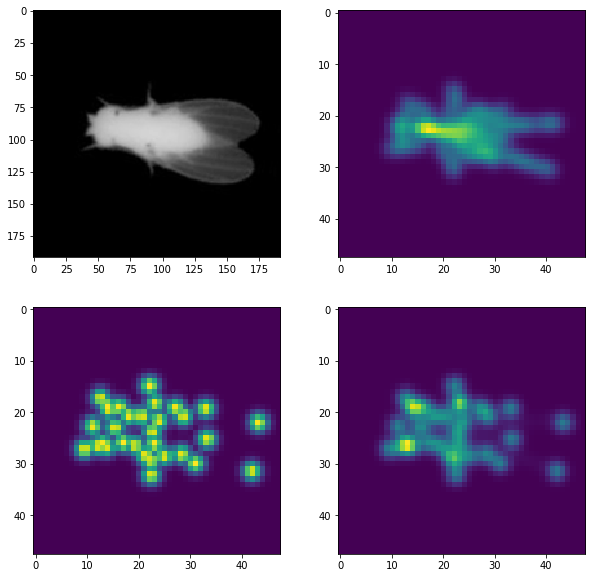

In [6]:
n_keypoints = train_generator.n_keypoints
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))
ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

# Define a model
Here you can define a model to train with your data. You can use our `StackedDenseNet` model, `StackedHourglass` model, `DeepLabCut` model, or the `LEAP` model. The default settings for each model should work well for most datasets, but you can customize the model architecture. Look at the doc strings for more information:

In [7]:
StackedDenseNet?

In [8]:
model = StackedDenseNet(data_generator=train_generator, n_stacks=2)
# model = DeepLabCut(train_generator)
# model = LEAP(train_generator)
# model = StackedHourglass(train_generator)
model.get_config()

W0924 17:29:23.786360 4342203840 deprecation.py:323] From /Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/keras/backend.py:4075: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0924 17:29:24.258202 4342203840 deprecation.py:506] From /Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_transitions': 6,
 'growth_rate': 48,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'subpixel': True,
 'shuffle': True,
 'downsample_factor': 2,
 'sigma': 5,
 'use_graph': True,
 'graph_scale': 0.1,
 'validation_split': 0.1,
 'datapath': '/Users/jake/deepposekit-data/datasets/fly/annotation_data_release.h5',
 'dataset': 'images',
 'output_shape': (48, 48),
 'n_train': 1350,
 'n_validation': 150,
 'random_seed': 1,
 'n_output_channels': 66,
 'augmenter': True,
 'n_keypoints': 32}

You can examine the model architecture to see the model's layers and number of parameters

In [9]:
model.train_model.summary()

Model: "StackedDenseNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 1) 0                                            
__________________________________________________________________________________________________
float (Float)                   (None, 192, 192, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
image_normalization (ImageNorma (None, 192, 192, 1)  0           float[0][0]                      
__________________________________________________________________________________________________
sub_pixel_downscaling (SubPixel (None, 96, 96, 4)    0           image_normalization[0][0]        
____________________________________________________________________________________

# Test the prediction speed
This generates a random set of input images for the model to test how fast the model can predict keypoint locations.

In [ ]:
data_size = (10000,
             train_generator.height,
             train_generator.width, 
             train_generator.n_channels)
x = np.random.randint(0, 255, data_size, dtype='uint8')
t0 = time.time()
y = model.predict(x, batch_size=100, verbose=1)
t1 = time.time()
print(x.shape[0]/(t1-t0))

# Define callbacks to enhance model training
Here you can define callbacks to pass to the model for use during training


`Logger` evaluates the validation set at the end of each epoch and saves the evaluation data to a HDF5 log file:

In [10]:
logger = Logger(HOME + '/deepposekit-data/datasets/fly/log_densenet.h5',
                validation_batch_size=10)


`ReduceLROnPlateau` automatically reduces the learning rate of the optimizer when the validation loss stops improving. This helps the model to reach a better optimum at the end of training:

In [11]:
reduce_lr = ReduceLROnPlateau('val_loss',
                              factor=0.2,
                              verbose=1)


`ModelCheckpoint` automatically saves the model when the validation loss improves at the end of each epoch. This allows you to automatically save the best performing model during training, without having to evaluate the performance manually:

In [12]:
model_checkpoint = ModelCheckpoint(HOME + '/deepposekit-data/datasets/fly/best_model_densenet.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   optimizer=False)


`EarlyStopping` automatically stops the training session when the validation loss stops improving for a set number of epochs, which is set with the `patience` argument. This allows you to save time when training your model if there's not more improvment:

In [13]:
early_stop = EarlyStopping('val_loss',
                           min_delta=0.001,
                           patience=50,
                           verbose=1)


Create a list of callbacks to pass to the model

In [14]:
callbacks = [logger, early_stop, reduce_lr, model_checkpoint]

# Fit the model

This fits the model for a set number of epochs with small batches of data. If you have a small dataset initially you can set `batch_size` to a small value and manually set `steps_per_epoch` to some large value, e.g. 500, to increase the number of batches per epoch, otherwise this is automatically determined by the size of the dataset. See the doc string for details:

In [ ]:
model.fit?

In [11]:
model.fit(batch_size=16,
          validation_batch_size=10,
          callbacks=callbacks,
          epochs=1000,
          n_workers=8,
          steps_per_epoch=None)

Epoch 1/1000
84/84 [==============================] - 45s 540ms/step - loss: 141.5929 - output_0_loss: 71.9562 - output_1_loss: 69.6367 - val_loss: 127.7636 - val_output_0_loss: 65.9062 - val_output_1_loss: 61.8574
evaluation_metrics: mean median (2.5%, 97.5%) - euclidean: 20.8619 13.9248 (1.5311, 74.3796) - mae: 12.8411 9.3500 (0.9800, 45.2200) - mse: 410.8777 97.0960 (1.1721, 2766.1602) - rmse: 14.7516 9.8464 (1.0826, 52.5943)

Epoch 00001: val_loss improved from inf to 127.76356, saving model to /home/jake/deepposekit-data/datasets/fly/best_model_fly_densenet.h5
Epoch 2/1000
84/84 [==============================] - 35s 411ms/step - loss: 123.4802 - output_0_loss: 65.3742 - output_1_loss: 58.1060 - val_loss: 114.6841 - val_output_0_loss: 63.1798 - val_output_1_loss: 51.5043
evaluation_metrics: mean median (2.5%, 97.5%) - euclidean: 20.0451 14.3249 (1.0671, 72.1541) - mae: 11.5309 9.2665 (0.6600, 40.3005) - mse: 414.4482 103.0886 (0.5694, 2603.1043) - rmse: 14.1740 10.1292 (0.7546, 51